# 1. Setup and Data Loading

Import necessary libraries and load the dataset. We'll filter the columns
to keep only the relevant ones identified.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from pandas.tseries.offsets import Day
import warnings

# Optional: Configure settings for better display
pd.set_option('display.max_columns', 50)
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore future warnings from seaborn/pandas

In [2]:

df = pd.read_csv(r'G:\Users\Clamfighter\Documents\GitHub\Football-Analytics\Data\football_data.csv', low_memory=False)



columns_to_keep = [
    "Div", "Date", "Time", "HomeTeam", "AwayTeam",
    "FTHG", "HG", "FTAG", "AG", "FTR", "Res", # Full Time Goals and Result
    "HTHG", "HTAG", "HTR",                 # Half Time Goals and Result
    "Attendance", "Referee",               # Match Info
    "HS", "AS", "HST", "AST", "HHW", "AHW", # Shots and Woodwork
    "HC", "AC",                            # Corners
    "HF", "AF", "HFKC", "AFKC",             # Fouls and Free Kicks Conceded
    "HO", "AO",                            # Offsides
    "HY", "AY", "HR", "AR",                 # Cards
    "HBP", "ABP"                           # Booking Points
]

# Filter columns that actually exist in the loaded DataFrame
columns_in_df = [col for col in columns_to_keep if col in df.columns]
df_filtered = df[columns_in_df].copy() # Use a copy to avoid SettingWithCopyWarning

# --- Data Cleaning: Handle potential alias columns ---
# Use FTHG if available, otherwise HG. Create FTHG if only HG exists.
if 'FTHG' not in df_filtered.columns and 'HG' in df_filtered.columns:
    df_filtered['FTHG'] = df_filtered['HG']
if 'FTAG' not in df_filtered.columns and 'AG' in df_filtered.columns:
    df_filtered['FTAG'] = df_filtered['AG']
if 'FTR' not in df_filtered.columns and 'Res' in df_filtered.columns:
    df_filtered['FTR'] = df_filtered['Res']

# Ensure essential columns exist after aliasing
essential_cols = ["Div", "Date", "Time", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]
missing_essentials = [col for col in essential_cols if col not in df_filtered.columns]
if missing_essentials:
    raise ValueError(f"Essential columns missing from the dataset: {missing_essentials}")

# --- Data Cleaning: Convert goal columns to numeric ---
goal_cols = ['FTHG', 'FTAG', 'HTHG', 'HTAG']
for col in goal_cols:
    if col in df_filtered.columns:
        df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce') # Convert to number, turn errors into NaN

# Drop rows where essential goal information is missing
df_filtered.dropna(subset=['FTHG', 'FTAG'], inplace=True)

print(f"\nFiltered DataFrame shape: {df_filtered.shape}")
print("Available columns after filtering:")
print(df_filtered.columns)

print("\nSample of filtered data:")
df_filtered


Filtered DataFrame shape: (55666, 36)
Available columns after filtering:
Index(['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'HG', 'FTAG',
       'AG', 'FTR', 'Res', 'HTHG', 'HTAG', 'HTR', 'Attendance', 'Referee',
       'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW', 'HC', 'AC', 'HF', 'AF', 'HFKC',
       'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP'],
      dtype='object')

Sample of filtered data:


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,HG,FTAG,AG,FTR,Res,HTHG,HTAG,HTR,Attendance,Referee,HS,AS,HST,AST,HHW,AHW,HC,AC,HF,AF,HFKC,AFKC,HO,AO,HY,AY,HR,AR,HBP,ABP
0,E0,11/08/2023,20:00,Burnley,Man City,0.0,NaN,3.0,NaN,A,NaN,0.0,2.0,A,NaN,C Pawson,6.0,17.0,1.0,8.0,NaN,NaN,6.0,5.0,11.0,8.0,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,NaN,NaN
1,E0,12/08/2023,12:30,Arsenal,Nott'm Forest,2.0,NaN,1.0,NaN,H,NaN,2.0,0.0,H,NaN,M Oliver,15.0,6.0,7.0,2.0,NaN,NaN,8.0,3.0,12.0,12.0,NaN,NaN,NaN,NaN,2.0,2.0,0.0,0.0,NaN,NaN
2,E0,12/08/2023,15:00,Bournemouth,West Ham,1.0,NaN,1.0,NaN,D,NaN,0.0,0.0,D,NaN,P Bankes,14.0,16.0,5.0,3.0,NaN,NaN,10.0,4.0,9.0,14.0,NaN,NaN,NaN,NaN,1.0,4.0,0.0,0.0,NaN,NaN
3,E0,12/08/2023,15:00,Brighton,Luton,4.0,NaN,1.0,NaN,H,NaN,1.0,0.0,H,NaN,D Coote,27.0,9.0,12.0,3.0,NaN,NaN,6.0,7.0,11.0,12.0,NaN,NaN,NaN,NaN,2.0,2.0,0.0,0.0,NaN,NaN
4,E0,12/08/2023,15:00,Everton,Fulham,0.0,NaN,1.0,NaN,A,NaN,0.0,0.0,D,NaN,S Attwell,19.0,9.0,9.0,2.0,NaN,NaN,10.0,4.0,12.0,6.0,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55678,NaN,25/03/2025,19:45,Altrincham,Solihull,1.0,NaN,1.0,NaN,D,NaN,1.0,0.0,H,NaN,J Westgate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,1.0,0.0,NaN,NaN
55679,NaN,25/03/2025,19:45,Boston Utd,Southend,3.0,NaN,0.0,NaN,H,NaN,0.0,0.0,D,NaN,N Smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,0.0,0.0,NaN,NaN
55680,NaN,25/03/2025,19:45,Rochdale,York,0.0,NaN,4.0,NaN,A,NaN,0.0,1.0,A,NaN,G Rollason,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0,0.0,NaN,NaN
55681,NaN,25/03/2025,19:45,Wealdstone,Aldershot,1.0,NaN,3.0,NaN,A,NaN,1.0,0.0,H,NaN,R Atkin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,NaN,NaN


# 2. Data Transformation


## 2.1. Data Transformation: Match-level to Team-level

The original data is one row per match. To analyze team performance and calculate autoregressive features (like rolling averages), it's better to have one row per team *per match*. We'll transform the data accordingly.

In [3]:
shared_cols = ['Div', 'Date', 'Time', 'Referee', 'Attendance', 'HTR', 'FTR']
shared_cols = [col for col in shared_cols if col in df_filtered.columns]

# Define mappings using actual column names present in df_filtered
home_stat_cols = {
    'Team': 'HomeTeam', 'Opponent': 'AwayTeam', 'Goals': 'FTHG', 'GoalsConceded': 'FTAG',
    'HTGoals': 'HTHG', 'HTGoalsConceded': 'HTAG',
    'Shots': 'HS', 'ShotsOnTarget': 'HST', 'HitWoodwork': 'HHW', 'Corners': 'HC',
    'Fouls': 'HF', 'FreeKicksConceded': 'HFKC', 'Offsides': 'HO',
    'YellowCards': 'HY', 'RedCards': 'HR', 'BookingPoints': 'HBP'
}

away_stat_cols = {
    'Team': 'AwayTeam', 'Opponent': 'HomeTeam', 'Goals': 'FTAG', 'GoalsConceded': 'FTHG',
    'HTGoals': 'HTAG', 'HTGoalsConceded': 'HTHG',
    'Shots': 'AS', 'ShotsOnTarget': 'AST', 'HitWoodwork': 'AHW', 'Corners': 'AC',
    'Fouls': 'AF', 'FreeKicksConceded': 'AFKC', 'Offsides': 'AO',
    'YellowCards': 'AY', 'RedCards': 'AR', 'BookingPoints': 'ABP'
}

# Filter mappings to only include columns present in df_filtered
home_stat_cols_present = {k: v for k, v in home_stat_cols.items() if v in df_filtered.columns}
away_stat_cols_present = {k: v for k, v in away_stat_cols.items() if v in df_filtered.columns}

# Extract dataframes
home_df = df_filtered[shared_cols + list(home_stat_cols_present.values())].copy()
home_df.columns = shared_cols + list(home_stat_cols_present.keys())
home_df["IsHome"] = True # Add indicator for home advantage

away_df = df_filtered[shared_cols + list(away_stat_cols_present.values())].copy()
away_df.columns = shared_cols + list(away_stat_cols_present.keys())
away_df["IsHome"] = False # Add indicator for home advantage

# Combine home and away perspectives
team_df = pd.concat([home_df, away_df], ignore_index=True)

# --- Data Cleaning and Sorting ---
# Convert Date column to datetime objects
team_df['Date'] = pd.to_datetime(team_df['Date'], dayfirst=True, errors='coerce')

# Convert Time column to datetime objects, handling potential errors
team_df['Time'] = pd.to_datetime(team_df['Time'], format='%H:%M', errors='coerce').dt.time # Keep only time part


# Drop rows where Date conversion failed
team_df.dropna(subset=['Date'], inplace=True)

# Sort data chronologically per team - ESSENTIAL for time series features
team_df = team_df.sort_values(by=['Team', 'Date', 'Time']).reset_index(drop=True)

# Convert relevant stat columns to numeric, coercing errors
stat_cols_to_numeric = [
    'Goals', 'GoalsConceded', 'HTGoals', 'HTGoalsConceded', 'Shots',
    'ShotsOnTarget', 'HitWoodwork', 'Corners', 'Fouls', 'FreeKicksConceded',
    'Offsides', 'YellowCards', 'RedCards', 'BookingPoints', 'Attendance'
]
for col in stat_cols_to_numeric:
    if col in team_df.columns:
        team_df[col] = pd.to_numeric(team_df[col], errors='coerce')

print(f"\nTransformed {df_filtered.shape[0]} matches --> {team_df.shape[0]} team-rows")
print("\nData types of team-level data:")
print(team_df.info())
team_df


Transformed 55666 matches --> 111332 team-rows

Data types of team-level data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111332 entries, 0 to 111331
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Div                107108 non-null  object        
 1   Date               111332 non-null  datetime64[ns]
 2   Time               29132 non-null   object        
 3   Referee            106870 non-null  object        
 4   Attendance         8136 non-null    float64       
 5   HTR                111330 non-null  object        
 6   FTR                111332 non-null  object        
 7   Team               111332 non-null  object        
 8   Opponent           111332 non-null  object        
 9   Goals              111332 non-null  float64       
 10  GoalsConceded      111332 non-null  float64       
 11  HTGoals            111330 non-null  float64       
 12  HTGoalsConceded    1

,Div,Date,Time,Referee,Attendance,HTR,FTR,Team,Opponent,Goals,GoalsConceded,HTGoals,HTGoalsConceded,Shots,ShotsOnTarget,HitWoodwork,Corners,Fouls,FreeKicksConceded,Offsides,YellowCards,RedCards,BookingPoints,IsHome
0,EC,2011-08-16,NaT,R Whitton,NaN,D,H,AFC Telford United,Cambridge,0.0,1.0,0.0,0.0,12.0,5.0,NaN,4.0,10.0,NaN,NaN,2.0,0.0,NaN,False
1,EC,2011-08-20,NaT,T Harrington,NaN,D,A,AFC Telford United,York,1.0,0.0,0.0,0.0,5.0,2.0,NaN,2.0,11.0,NaN,NaN,1.0,0.0,NaN,False
2,EC,2011-08-23,NaT,D Bond,NaN,D,A,AFC Telford United,Lincoln,1.0,2.0,0.0,0.0,8.0,6.0,NaN,5.0,15.0,NaN,NaN,2.0,0.0,NaN,True
3,EC,2011-08-27,NaT,P Banks,NaN,D,H,AFC Telford United,Newport County,2.0,1.0,1.0,1.0,9.0,4.0,NaN,1.0,10.0,NaN,NaN,2.0,0.0,NaN,True
4,EC,2011-08-29,NaT,D Handley,NaN,H,D,AFC Telford United,Tamworth,2.0,2.0,0.0,1.0,12.0,5.0,NaN,1.0,13.0,NaN,NaN,3.0,0.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111327,NaN,2025-03-04,19:45:00,J O'Connor,NaN,A,A,York,Altrincham,1.0,2.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,True
111328,NaN,2025-03-08,17:30:00,O Yates,NaN,D,D,York,Forest Green,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,True
111329,NaN,2025-03-15,15:00:00,A Farmer,NaN,D,A,York,Yeovil,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,NaN,False
111330,NaN,2025-03-22,15:00:00,C Walchester,NaN,D,H,York,Braintree Town,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,False


## 2.2 Compute Running League Points & Opponent Rankings

In [4]:
# Calculate match points based on full time result
def calc_points(result):
    if result == 'W':  # Update this depending on how wins are coded in your FTR
        return 3
    elif result == 'D':
        return 1
    else:
        return 0

team_df['Points'] = team_df['FTR'].apply(calc_points)
team_df['CumulativePoints'] = team_df.sort_values(by=['Date', 'Time']).groupby('Team')['Points'].cumsum()

# Rank teams by cumulative points on each matchday and split into thirds.
def assign_league_third(group):
    group = group.sort_values(by='CumulativePoints', ascending=False)
    total = len(group)
    group['LeaguePosition'] = ['Top' if i < total/3 
                               else 'Middle' if i < 2*total/3 
                               else 'Bottom' 
                               for i in range(total)]
    return group

# Group by match date (or matchday if available) and assign positions across all divisions
team_df = team_df.groupby('Date').apply(assign_league_third).reset_index(drop=True)


C:\Users\Jack\AppData\Local\Temp\ipykernel_17276\1736797701.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_df = team_df.groupby('Date').apply(assign_league_third).reset_index(drop=True)


## 2.3 Calculate Results  

In [5]:
def team_result(row):
    if row['IsHome']:
        if row['FTR'] == 'H':
            return 'W'
        elif row['FTR'] == 'D':
            return 'D'
        else:
            return 'L'
    else:
        if row['FTR'] == 'A':
            return 'W'
        elif row['FTR'] == 'D':
            return 'D'
        else:
            return 'L'

team_df['Result'] = team_df.apply(team_result, axis=1)
team_df = team_df.sort_values(by=['Team', 'Date', 'Time']).reset_index(drop=True)
team_df['NextOutcome'] = team_df.groupby('Team')['Result'].shift(-1)



## 2.4 Calculate Streaks

In [6]:
def add_multiple_streaks(group):
    win_streak = []
    unbeaten_streak = []
    loss_streak = []
    no_wins_streak = []
    
    current_win_streak = 0
    current_unbeaten_streak = 0
    current_loss_streak = 0
    current_no_wins_streak = 0
    
    # Iterate over the team's matches using the recoded "Result"
    for result in group['Result']:
        # WinStreak: increment if win, else reset
        if result == 'W':
            current_win_streak += 1
        else:
            current_win_streak = 0
        win_streak.append(current_win_streak)
        
        # UnbeatenStreak: increment if not a loss (win or draw), else reset
        if result != 'L':
            current_unbeaten_streak += 1
        else:
            current_unbeaten_streak = 0
        unbeaten_streak.append(current_unbeaten_streak)
        
        # LossStreak: increment if loss, else reset
        if result == 'L':
            current_loss_streak += 1
        else:
            current_loss_streak = 0
        loss_streak.append(current_loss_streak)
        
        # NoWinsStreak: increment if not a win (draw or loss), else reset
        if result != 'W':
            current_no_wins_streak += 1
        else:
            current_no_wins_streak = 0
        no_wins_streak.append(current_no_wins_streak)
    
    group = group.copy()  # avoid modifying the original group
    group['WinStreak'] = win_streak
    group['UnbeatenStreak'] = unbeaten_streak
    group['LossStreak'] = loss_streak
    group['NoWinsStreak'] = no_wins_streak
    return group

# Apply the streak computation for each team
team_df = team_df.groupby('Team').apply(add_multiple_streaks).reset_index(drop=True)


C:\Users\Jack\AppData\Local\Temp\ipykernel_17276\606963333.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  team_df = team_df.groupby('Team').apply(add_multiple_streaks).reset_index(drop=True)


In [7]:
team_df.sort_values('WinStreak',ascending=False).head(1)

,Div,Date,Time,Referee,Attendance,HTR,FTR,Team,Opponent,Goals,GoalsConceded,HTGoals,HTGoalsConceded,Shots,ShotsOnTarget,HitWoodwork,Corners,Fouls,FreeKicksConceded,Offsides,YellowCards,RedCards,BookingPoints,IsHome,Points,CumulativePoints,LeaguePosition,Result,NextOutcome,WinStreak,UnbeatenStreak,LossStreak,NoWinsStreak
57759,E0,2020-02-24,20:00:00,J Moss,NaN,D,H,Liverpool,West Ham,3.0,2.0,1.0,1.0,25.0,7.0,NaN,16.0,4.0,NaN,NaN,0.0,0.0,NaN,True,0,161,Middle,W,L,18,44,0,0


In [8]:
team_df.sort_values('UnbeatenStreak',ascending=False).head(1)

,Div,Date,Time,Referee,Attendance,HTR,FTR,Team,Opponent,Goals,GoalsConceded,HTGoals,HTGoalsConceded,Shots,ShotsOnTarget,HitWoodwork,Corners,Fouls,FreeKicksConceded,Offsides,YellowCards,RedCards,BookingPoints,IsHome,Points,CumulativePoints,LeaguePosition,Result,NextOutcome,WinStreak,UnbeatenStreak,LossStreak,NoWinsStreak
57759,E0,2020-02-24,20:00:00,J Moss,NaN,D,H,Liverpool,West Ham,3.0,2.0,1.0,1.0,25.0,7.0,NaN,16.0,4.0,NaN,NaN,0.0,0.0,NaN,True,0,161,Middle,W,L,18,44,0,0


In [9]:
team_df.sort_values('NoWinsStreak',ascending=False).head(1)

,Div,Date,Time,Referee,Attendance,HTR,FTR,Team,Opponent,Goals,GoalsConceded,HTGoals,HTGoalsConceded,Shots,ShotsOnTarget,HitWoodwork,Corners,Fouls,FreeKicksConceded,Offsides,YellowCards,RedCards,BookingPoints,IsHome,Points,CumulativePoints,LeaguePosition,Result,NextOutcome,WinStreak,UnbeatenStreak,LossStreak,NoWinsStreak
35524,E1,2008-08-30,NaT,G Salisbury,NaN,D,H,Derby,Barnsley,0.0,2.0,0.0,0.0,12.0,6.0,NaN,7.0,19.0,NaN,NaN,1.0,0.0,NaN,False,0,69,Top,L,W,0,0,2,36


In [10]:
team_df.sort_values('LossStreak',ascending=False).head(1)

,Div,Date,Time,Referee,Attendance,HTR,FTR,Team,Opponent,Goals,GoalsConceded,HTGoals,HTGoalsConceded,Shots,ShotsOnTarget,HitWoodwork,Corners,Fouls,FreeKicksConceded,Offsides,YellowCards,RedCards,BookingPoints,IsHome,Points,CumulativePoints,LeaguePosition,Result,NextOutcome,WinStreak,UnbeatenStreak,LossStreak,NoWinsStreak
55093,EC,2009-03-28,NaT,W Barratt,NaN,H,H,Lewes,Forest Green,1.0,4.0,1.0,2.0,5.0,2.0,NaN,1.0,6.0,NaN,NaN,1.0,2.0,NaN,False,0,5,Bottom,L,W,0,0,18,18


# 3. Calculating Win / Loss Streak Probabilities

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_streak_outcome_probs(df, streak_columns, max_streak_length=7):
    """
    Generate outcome probability visuals (bar + stacked area) for each streak column.

    Parameters:
    - df: DataFrame with 'NextOutcome' and the streak columns
    - streak_columns: list of streak column names (e.g., ['WinStreak', 'NoLossStreak_viz'])
    - max_streak_length: max streak length to include in plots
    """

    # Style setup
    sns.set_style("whitegrid")
    sns.set_context("talk", font_scale=0.9)

    outcomes = ['W', 'D', 'L']
    colors = {'W': '#55A868', 'D': '#CFCFCF', 'L': '#C44E52'}
    labels = {'W': 'Win', 'D': 'Draw', 'L': 'Loss'}

    for streak_col in streak_columns:
        # --- Step 1: Calculate conditional probabilities ---
        results_table = {}
        for s in range(0, max_streak_length + 1):
            filtered = df[df[streak_col] == s]
            results_table[s] = filtered['NextOutcome'].value_counts(normalize=True)

        # --- Step 2: Convert to DataFrame ---
        df_probs = pd.DataFrame(results_table).T.fillna(0)
        df_probs = df_probs[['W', 'D', 'L']].sort_index()
        streaks = df_probs.index
        x = np.arange(len(streaks))
        width = 0.25

        # --- Chart 1: Grouped Bar Chart ---
        fig, ax = plt.subplots(figsize=(10, 6))

        for i, outcome in enumerate(outcomes):
            ax.bar(x + i * width - width, df_probs[outcome],
                   width=width, label=labels[outcome],
                   color=colors[outcome], edgecolor='white', linewidth=0.6, alpha=0.9)

        ax.set_title(f"Match Outcome by {streak_col}", fontsize=16, weight='bold')
        ax.set_xlabel(f"{streak_col} Length", fontsize=12)
        ax.set_ylabel("Probability", fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(streaks)
        ax.set_ylim(0, 1.0)
        ax.grid(axis='y', alpha=0.2)
        ax.tick_params(labelsize=11)
        sns.despine()

        ax.legend(
            title='Next Result',
            frameon=False,
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            borderaxespad=0,
            fontsize=11
        )

        plt.tight_layout()
        plt.show()

        # --- Chart 2: Stacked Area Chart ---
        fig, ax = plt.subplots(figsize=(10, 6))

        stack_vals = np.vstack([df_probs[o] for o in outcomes])
        cumulative = np.cumsum(stack_vals, axis=0)

        for i, outcome in enumerate(outcomes):
            base = cumulative[i - 1] if i > 0 else np.zeros_like(streaks)
            ax.fill_between(streaks, base, cumulative[i],
                            label=labels[outcome],
                            color=colors[outcome], alpha=0.85)

        ax.set_title(f"Outcome Share by {streak_col} (100%)", fontsize=16, weight='bold')
        ax.set_xlabel(f"{streak_col} Length", fontsize=12)
        ax.set_ylabel("Proportion of Outcomes", fontsize=12)
        ax.set_xticks(streaks)
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.set_ylim(0, 1.0)
        ax.grid(axis='y', alpha=0.2)
        ax.tick_params(labelsize=11)
        sns.despine()

        ax.legend(
            title='Next Result',
            frameon=False,
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            borderaxespad=0,
            fontsize=11
        )

        plt.tight_layout()
        plt.show()


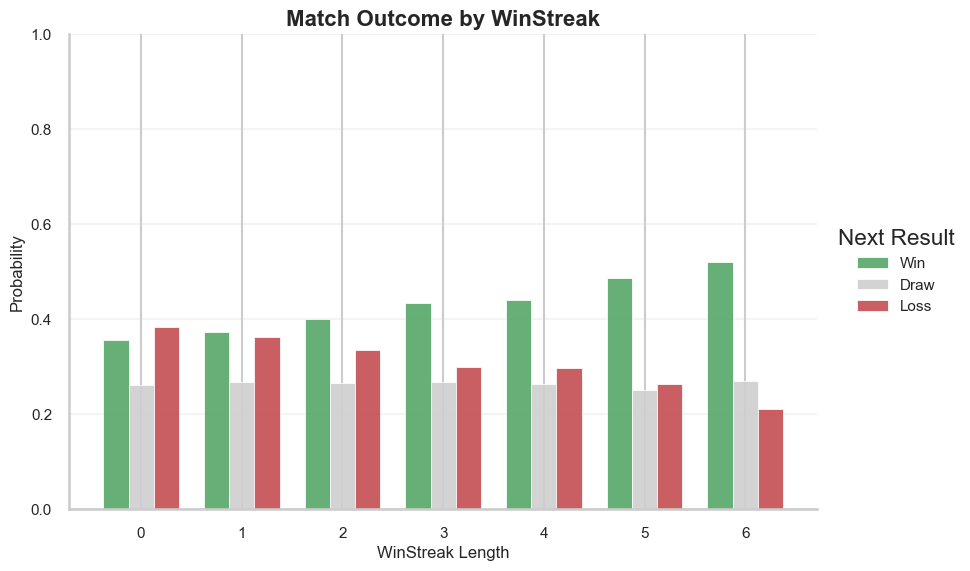

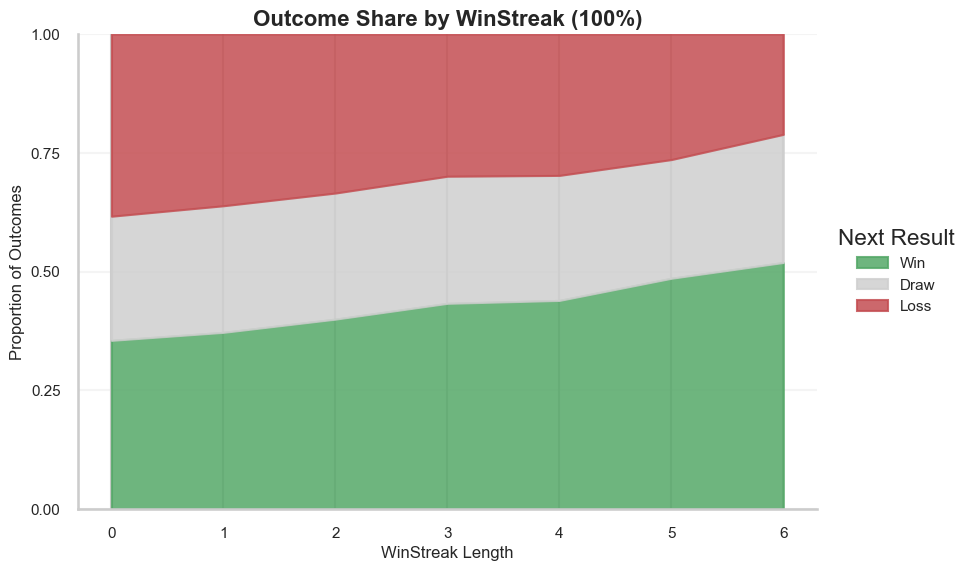

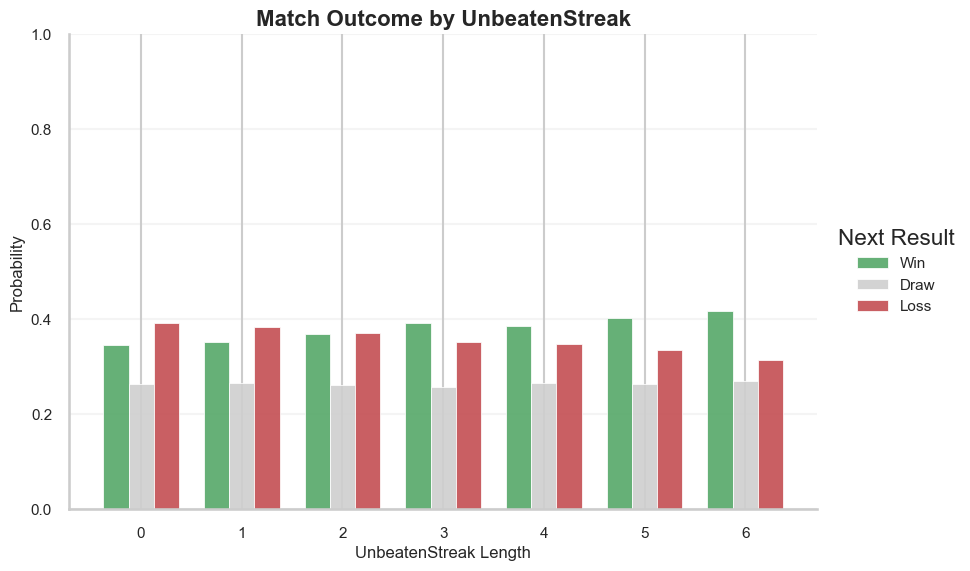

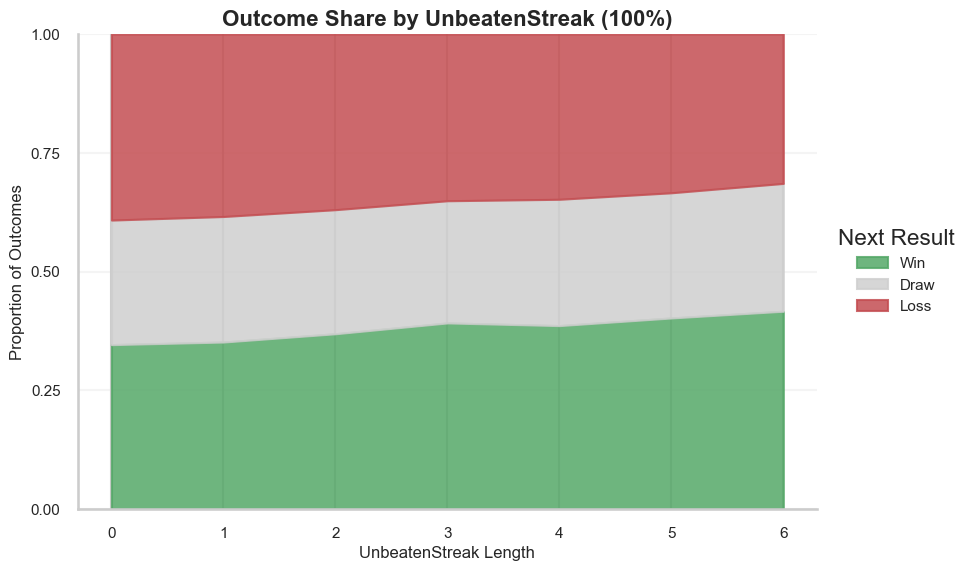

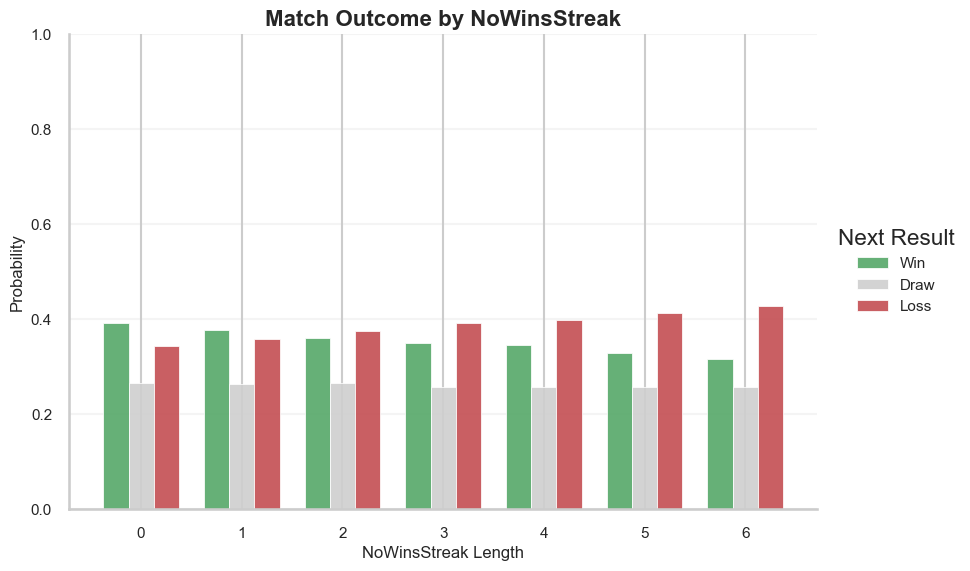

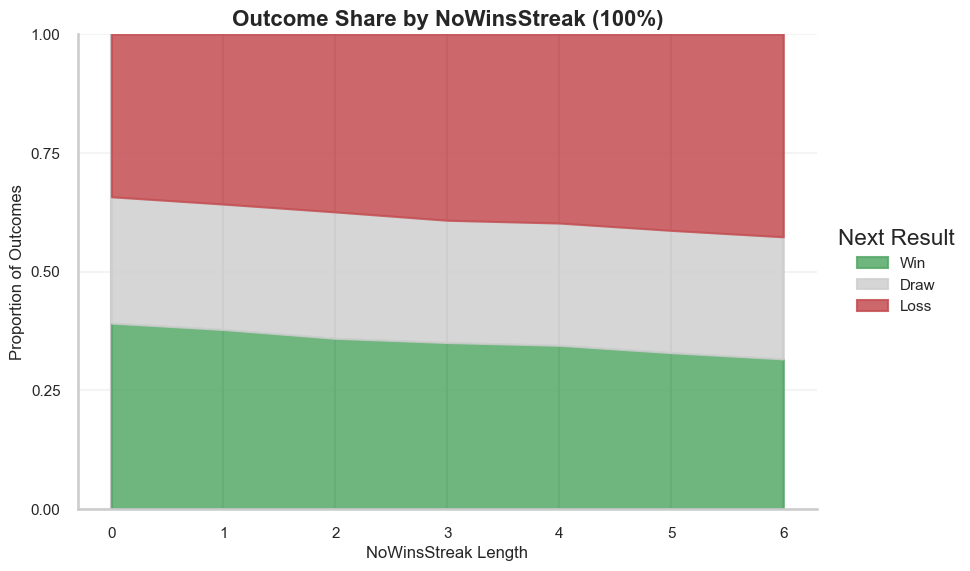

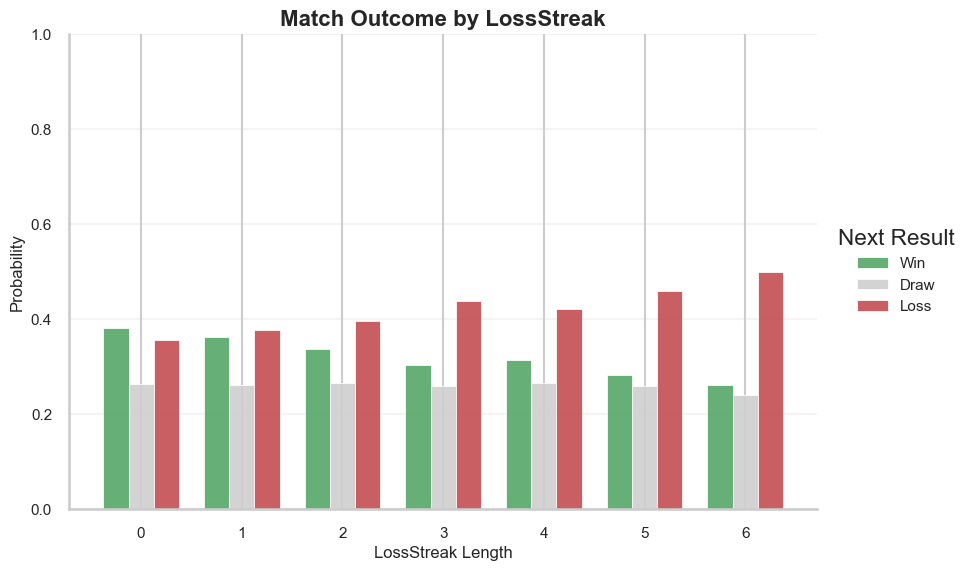

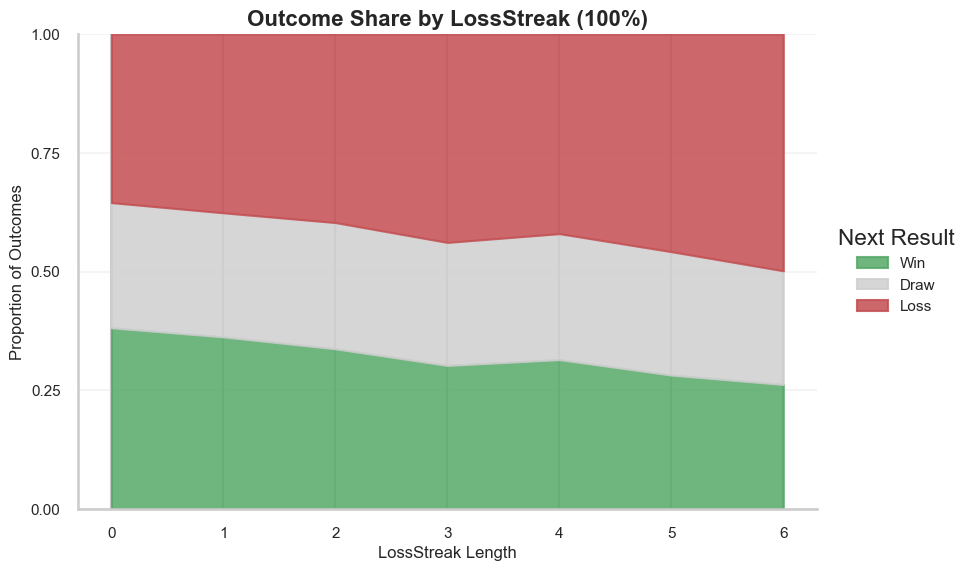

In [12]:
plot_streak_outcome_probs(team_df, ['WinStreak','UnbeatenStreak','NoWinsStreak','LossStreak'], max_streak_length=6)


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_draw_trend_by_streak(df, streak_columns, max_streak_length=6):
    """
    Plot draw probabilities across streak lengths for each streak column provided.

    Parameters:
    - df: DataFrame with 'NextOutcome' and streak columns
    - streak_columns: list of column names representing streak types
    - max_streak_length: maximum streak length to analyze
    """
    sns.set_style("whitegrid")
    sns.set_context("talk", font_scale=0.9)

    for streak_col in streak_columns:
        draw_probs = {}
        for s in range(0, max_streak_length + 1):
            filtered = df[df[streak_col] == s]
            if not filtered.empty:
                draw_prob = filtered['NextOutcome'].value_counts(normalize=True).get('D', 0)
                draw_probs[s] = draw_prob
            else:
                draw_probs[s] = np.nan  # no data for that streak length

        # Convert to Series for plotting
        draw_series = pd.Series(draw_probs).sort_index()

        # Plot
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(draw_series.index, draw_series.values, marker='o', color='#CFCFCF', linewidth=2.5, label='Draw Probability')

        # Optional: draw average line
        avg = draw_series.mean(skipna=True)
        ax.axhline(avg, linestyle='--', color='#999999', linewidth=1.5, alpha=0.7, label=f'Avg: {avg:.1%}')

        # Styling
        ax.set_title(f"🟡 Draw Probability by {streak_col}", fontsize=16, weight='bold')
        ax.set_xlabel(f"{streak_col} Length", fontsize=12)
        ax.set_ylabel("Probability of Draw", fontsize=12)
        ax.set_ylim(0, 1.0)
        ax.set_xticks(draw_series.index)
        ax.grid(alpha=0.3)
        ax.tick_params(labelsize=11)
        sns.despine()

        # Legend
        ax.legend(frameon=False, loc='upper right', fontsize=11)

        plt.tight_layout()
        plt.show()


C:\Users\Jack\AppData\Local\Temp\ipykernel_17276\3079909928.py:52: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


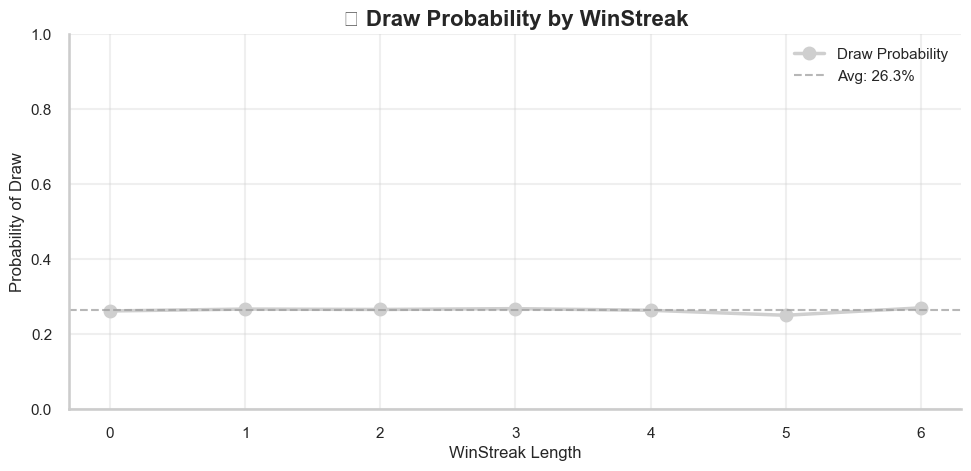

C:\Users\Jack\AppData\Local\Temp\ipykernel_17276\3079909928.py:52: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


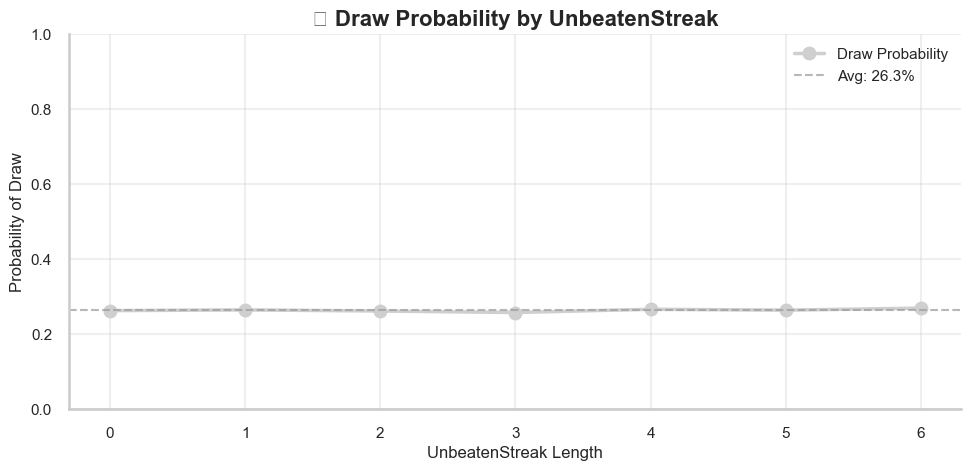

C:\Users\Jack\AppData\Local\Temp\ipykernel_17276\3079909928.py:52: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


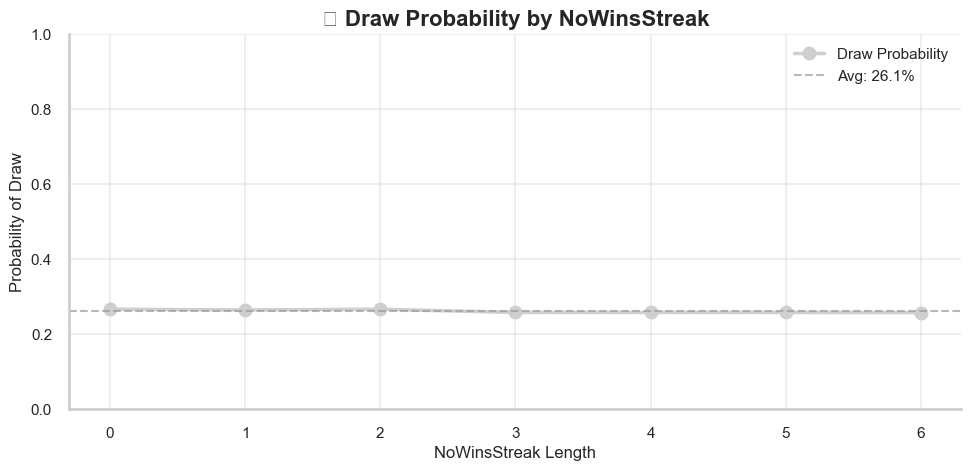

C:\Users\Jack\AppData\Local\Temp\ipykernel_17276\3079909928.py:52: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


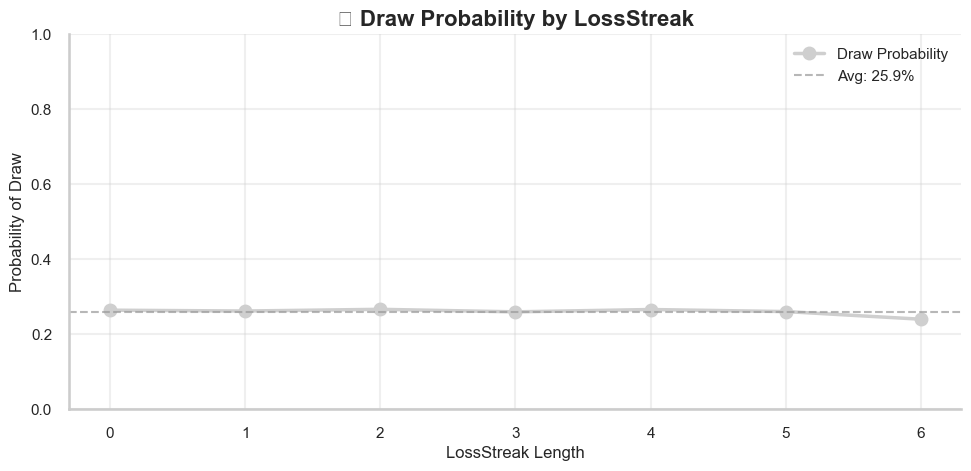

In [14]:
plot_draw_trend_by_streak(team_df, ['WinStreak','UnbeatenStreak','NoWinsStreak','LossStreak'], max_streak_length=6)


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_draw_trends_combined(df, streak_columns, max_streak_length=6):
    """
    Plot draw probabilities across streak lengths for multiple streak types on one combined line chart.

    Parameters:
    - df: DataFrame with 'NextOutcome' and the streak columns
    - streak_columns: list of streak column names to plot
    - max_streak_length: max streak length to include
    """
    sns.set_style("whitegrid")
    sns.set_context("talk", font_scale=0.9)

    draw_data = []

    for streak_col in streak_columns:
        for s in range(0, max_streak_length + 1):
            filtered = df[df[streak_col] == s]
            if not filtered.empty:
                draw_prob = filtered['NextOutcome'].value_counts(normalize=True).get('D', np.nan)
                draw_data.append({'StreakLength': s, 'DrawProb': draw_prob, 'StreakType': streak_col})

    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(draw_data)

    # Plotting
    plt.figure(figsize=(12, 6))
    palette = sns.color_palette("Set2", n_colors=len(streak_columns))

    sns.lineplot(
        data=plot_df,
        x='StreakLength',
        y='DrawProb',
        hue='StreakType',
        marker='o',
        linewidth=2.5,
        palette=palette
    )

    # Draw average line for reference
    overall_avg = plot_df['DrawProb'].mean(skipna=True)
    plt.axhline(overall_avg, linestyle='--', color='gray', alpha=0.6, label=f'Overall Avg: {overall_avg:.1%}')

    # Styling
    plt.title("🟡 Draw Probability by Streak Type", fontsize=17, weight='bold')
    plt.xlabel("Streak Length", fontsize=13)
    plt.ylabel("Probability of Draw", fontsize=13)
    plt.ylim(0, 1)
    plt.xticks(range(0, max_streak_length + 1))
    plt.grid(alpha=0.2)
    plt.legend(title="Streak Type", frameon=False, fontsize=11)
    sns.despine()

    plt.tight_layout()
    plt.show()


C:\Users\Jack\AppData\Local\Temp\ipykernel_17276\404019701.py:58: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


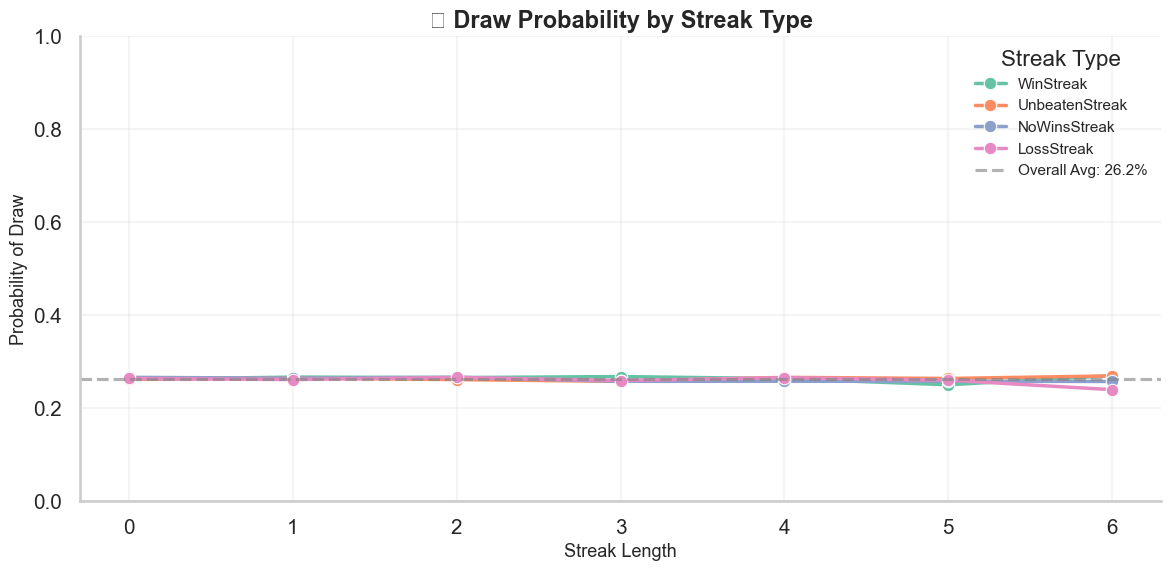

In [16]:
plot_draw_trends_combined(
    team_df,
    streak_columns=['WinStreak','UnbeatenStreak','NoWinsStreak','LossStreak'],
    max_streak_length=6
)


# 4. Analysing All Streak Probabilities

In [17]:
def compute_sequence_outcomes(df, window=4, min_count=30):
    """
    Analyze how past N-game result sequences affect the next match outcome.

    Parameters:
    - df: DataFrame with ['Team', 'Date', 'Result', 'NextOutcome']
    - window: length of form sequence (e.g., 4-game streak)
    - min_count: only include patterns that occur at least this many times

    Returns:
    - DataFrame with [FormSequence, P(Win), P(Draw), P(Loss), Count]
    """
    df = df.copy()
    df = df.sort_values(by=['Team', 'Date']).reset_index(drop=True)

    # Create shifted columns for each previous result
    for i in range(1, window + 1):
        df[f'Result_{i}'] = df.groupby('Team')['Result'].shift(i)

    # Keep only rows where all shifts are non-null
    sequence_cols = [f'Result_{i}' for i in range(window, 0, -1)]
    df = df.dropna(subset=sequence_cols + ['NextOutcome'])

    # Join the shifted results into a full sequence string
    df['FormSequence'] = df[sequence_cols].agg(''.join, axis=1)

    # Count next outcomes by sequence
    outcome_dist = (
        df.groupby('FormSequence')['NextOutcome']
        .value_counts(normalize=True)
        .unstack()
        .fillna(0)
    )

    # Add sample count
    outcome_dist['Count'] = df.groupby('FormSequence')['NextOutcome'].count()

    # Filter for frequent patterns
    outcome_dist = outcome_dist[outcome_dist['Count'] >= min_count]

    return outcome_dist.sort_values('Count', ascending=False)


In [18]:
result_sequences = compute_sequence_outcomes(team_df, window=4, min_count=30)
result_sequences


NextOutcome,D,L,W,Count
FormSequence,,,,
WWWW,0.266251,0.260998,0.472751,3046
LLLL,0.251804,0.454139,0.294057,2911
LWLL,0.256386,0.422651,0.320964,2075
WWLW,0.247006,0.337325,0.415669,2004
LLWL,0.271593,0.414878,0.313530,2003
...,...,...,...,...
DLDD,0.263736,0.375000,0.361264,728
DDDL,0.248963,0.387275,0.363762,723
DWDD,0.245042,0.376771,0.378187,706


C:\Users\Jack\AppData\Local\Temp\ipykernel_17276\2529256872.py:15: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


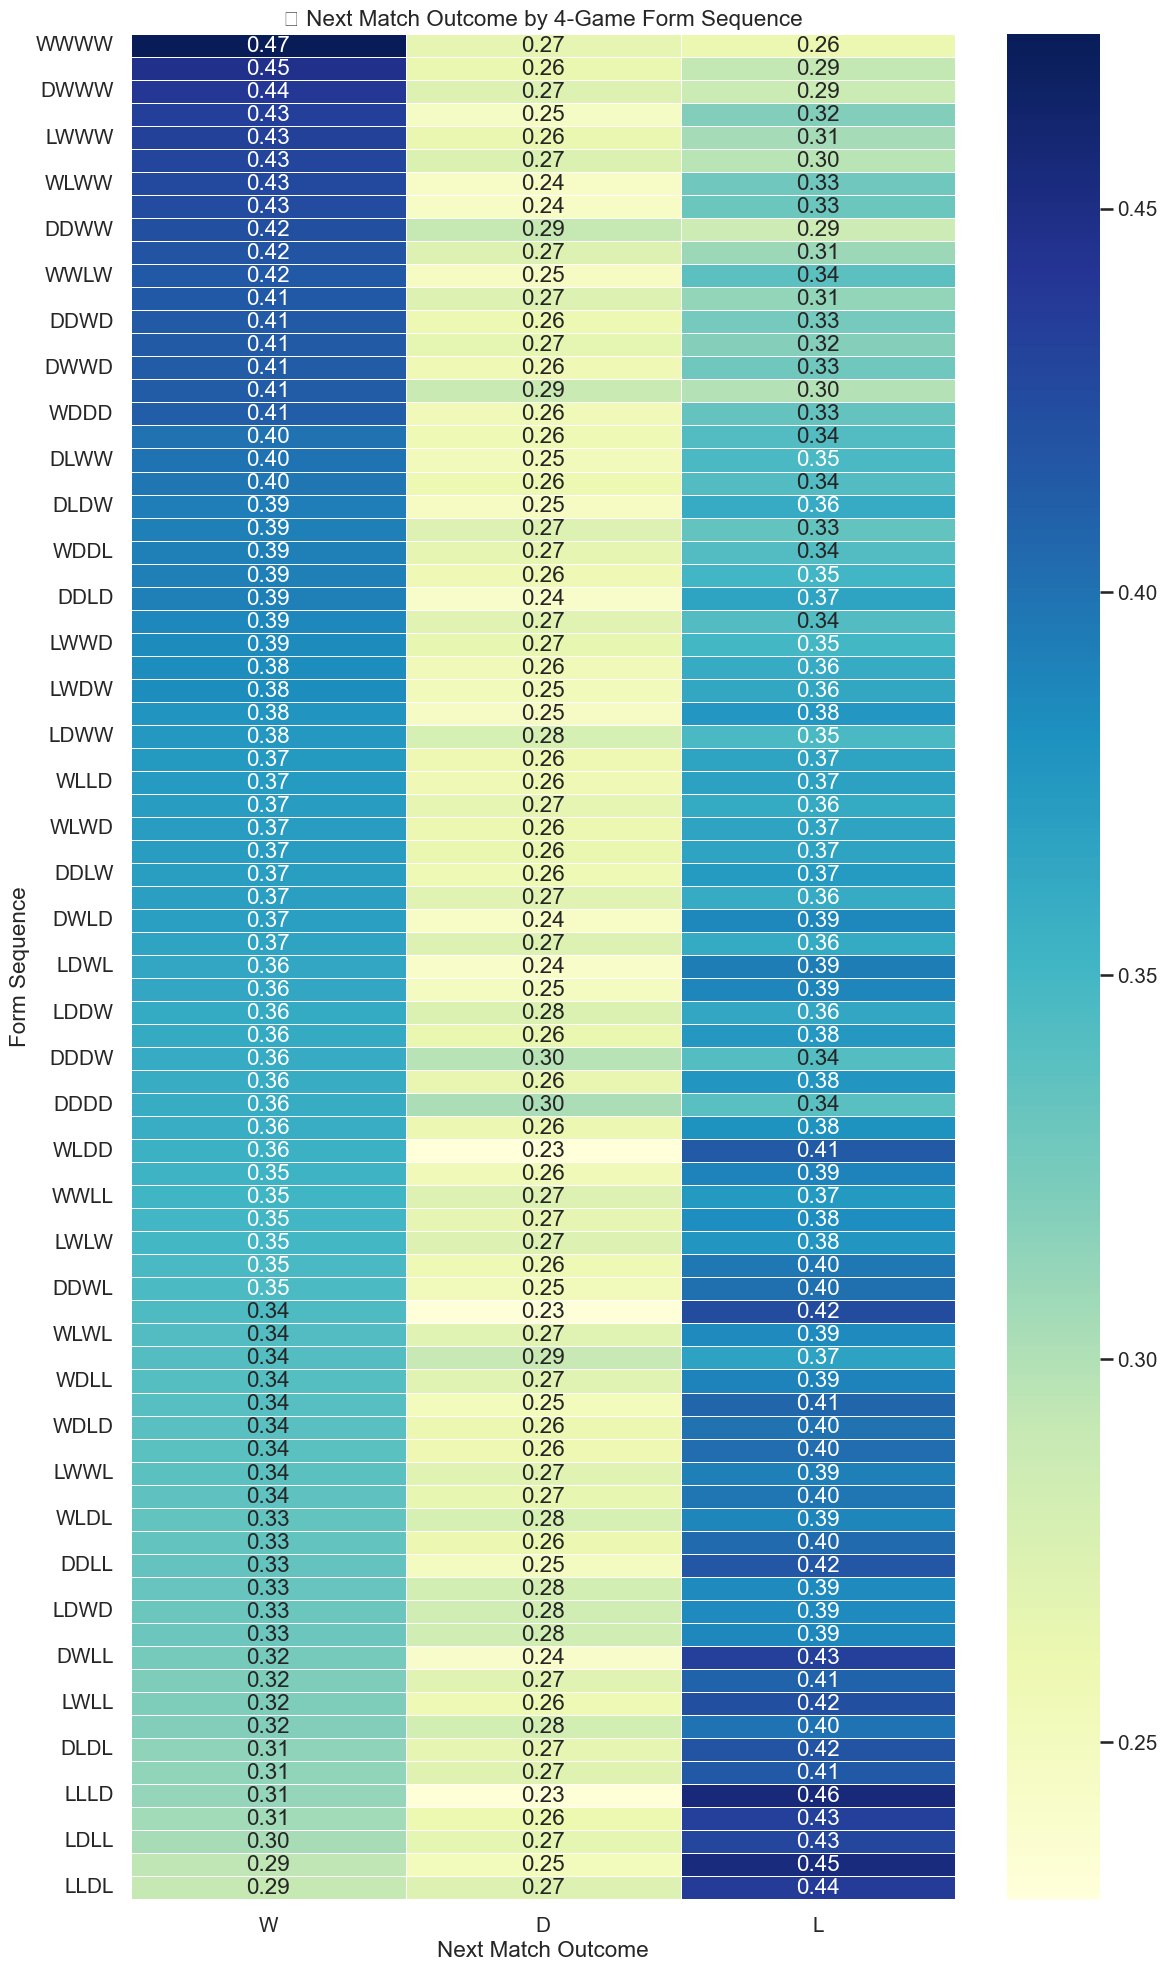

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort or cluster
outcome_matrix = result_sequences[['W', 'D', 'L']]

# Optional: sort by P(Win) descending
outcome_matrix = outcome_matrix.sort_values('W', ascending=False)

plt.figure(figsize=(12, 20))
sns.heatmap(outcome_matrix, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=0.5)
plt.title('🔍 Next Match Outcome by 4-Game Form Sequence')
plt.xlabel('Next Match Outcome')
plt.ylabel('Form Sequence')
plt.tight_layout()
plt.show()


In [20]:
# From your previous result_sequences DataFrame
probs = result_sequences[['W', 'D', 'L']]

variability = pd.DataFrame({
    'Mean': probs.mean(),
    'StdDev': probs.std(),
    'Range': probs.max() - probs.min()
}).T.round(3)

print("📊 Outcome Variability Across All 4-Game Sequences:")
print(variability)


📊 Outcome Variability Across All 4-Game Sequences:
NextOutcome      W      D      L
Mean         0.369  0.263  0.368
StdDev       0.039  0.014  0.041
Range        0.182  0.072  0.195


C:\Users\Jack\AppData\Local\Temp\ipykernel_17276\2028431228.py:13: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


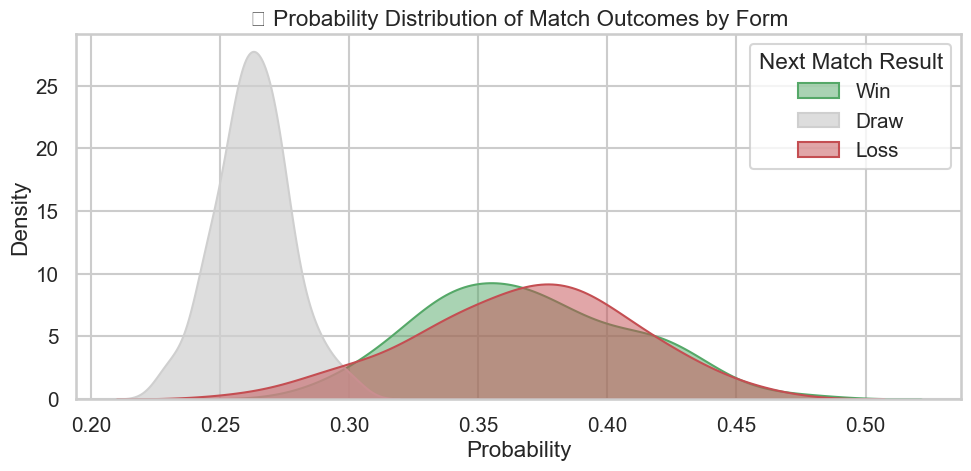

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.kdeplot(result_sequences['W'], label='Win', color='#55A868', fill=True, alpha=0.5)
sns.kdeplot(result_sequences['D'], label='Draw', color='#CFCFCF', fill=True, alpha=0.7)
sns.kdeplot(result_sequences['L'], label='Loss', color='#C44E52', fill=True, alpha=0.5)

plt.title("🎯 Probability Distribution of Match Outcomes by Form")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.legend(title="Next Match Result")
plt.tight_layout()
plt.show()


# Analysing Probabilities vs Strong opponent

In [22]:
def add_opponent_top6_flag(team_df):
    df = team_df.copy()

    # Create a helper to calculate points
    def result_to_points(result):
        if result == 'W':
            return 3
        elif result == 'D':
            return 1
        else:
            return 0

    df['PointsEarned'] = df['Result'].apply(result_to_points)

    # For each division + season, calculate running table
    df['Season'] = df['Date'].dt.year  # crude but can be refined
    df.sort_values(by=['Div', 'Season', 'Date', 'Time'], inplace=True)

    # Track cumulative points per team
    df['MatchIndex'] = df.groupby(['Div', 'Season', 'Team']).cumcount()
    df['CumulativePoints'] = df.groupby(['Div', 'Season', 'Team'])['PointsEarned'].cumsum().shift(1)

    # Fill missing with 0 at season start
    df['CumulativePoints'] = df['CumulativePoints'].fillna(0)

    # Build a mini-table of standings by match date
    standings = (
        df.groupby(['Div', 'Season', 'Date'])[['Team', 'CumulativePoints']]
        .apply(lambda g: g.sort_values('CumulativePoints', ascending=False).reset_index(drop=True))
        .reset_index()
    )

    # Tag top 6 teams by match date
    standings['Top6'] = standings.groupby(['Div', 'Season', 'Date']).cumcount() < 6
    top6_lookup = standings[standings['Top6']][['Div', 'Season', 'Date', 'Team']]
    top6_lookup['OpponentTop6'] = True

    # Merge this back into team_df on Opponent side
    df = df.merge(
        top6_lookup,
        how='left',
        left_on=['Div', 'Season', 'Date', 'Opponent'],
        right_on=['Div', 'Season', 'Date', 'Team']
    )

    df['OpponentTop6'] = df['OpponentTop6'].fillna(False)

    return df.drop(columns=['Team_y']).rename(columns={'Team_x': 'Team'})
team_df = add_opponent_top6_flag(team_df)



In [23]:
# Example: WinStreak = 3, vs Top6 and Not Top6
streak_len = 3
col = 'WinStreak'

for flag in [True, False]:
    filtered = team_df[(team_df[col] == streak_len) & (team_df['OpponentTop6'] == flag)]
    probs = filtered['NextOutcome'].value_counts(normalize=True)
    print(f"\nWinStreak {streak_len} vs {'Top 6' if flag else 'Others'}:\n", probs)



WinStreak 3 vs Top 6:
 NextOutcome
W    0.442502
L    0.294553
D    0.262946
Name: proportion, dtype: float64

WinStreak 3 vs Others:
 NextOutcome
W    0.426637
L    0.302483
D    0.270880
Name: proportion, dtype: float64


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_draw_trends_combined(df, streak_columns, max_streak_length=6):
    """
    Plot draw probabilities across streak lengths for multiple streak types on one combined line chart.

    Parameters:
    - df: DataFrame with 'NextOutcome' and the streak columns
    - streak_columns: list of streak column names to plot
    - max_streak_length: max streak length to include
    """
    sns.set_style("whitegrid")
    sns.set_context("talk", font_scale=0.9)

    draw_data = []

    for streak_col in streak_columns:
        for s in range(0, max_streak_length + 1):
            filtered = df[df[streak_col] == s]
            if not filtered.empty:
                draw_prob = filtered['NextOutcome'].value_counts(normalize=True).get('D', np.nan)
                draw_data.append({'StreakLength': s, 'DrawProb': draw_prob, 'StreakType': streak_col})

    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(draw_data)

    # Plotting
    plt.figure(figsize=(12, 6))
    palette = sns.color_palette("Set2", n_colors=len(streak_columns))

    sns.lineplot(
        data=plot_df,
        x='StreakLength',
        y='DrawProb',
        hue='StreakType',
        marker='o',
        linewidth=2.5,
        palette=palette
    )

    # Draw average line for reference
    overall_avg = plot_df['DrawProb'].mean(skipna=True)
    plt.axhline(overall_avg, linestyle='--', color='gray', alpha=0.6, label=f'Overall Avg: {overall_avg:.1%}')

    # Styling
    plt.title("🟡 Draw Probability by Streak Type", fontsize=17, weight='bold')
    plt.xlabel("Streak Length", fontsize=13)
    plt.ylabel("Probability of Draw", fontsize=13)
    plt.ylim(0, 1)
    plt.xticks(range(0, max_streak_length + 1))
    plt.grid(alpha=0.2)
    plt.legend(title="Streak Type", frameon=False, fontsize=11)
    sns.despine()

    plt.tight_layout()
    plt.show()


In [25]:
team_df['WinStreak_vsTop6'] = np.where(team_df['OpponentTop6'], team_df['WinStreak'], np.nan)
team_df['WinStreak_vsOthers'] = np.where(~team_df['OpponentTop6'], team_df['WinStreak'], np.nan)
team_df['LossStreak_vsTop6'] = np.where(team_df['OpponentTop6'], team_df['LossStreak'], np.nan)
team_df['LossStreak_vsOthers'] = np.where(~team_df['OpponentTop6'], team_df['LossStreak'], np.nan)

team_df['NoWinsStreak_vsTop6'] = np.where(team_df['OpponentTop6'], team_df['NoWinsStreak'], np.nan)
team_df['NoWinsStreak_vsOthers'] = np.where(~team_df['OpponentTop6'], team_df['NoWinsStreak'], np.nan)
team_df['UnbeatenStreak_vsTop6'] = np.where(team_df['OpponentTop6'], team_df['UnbeatenStreak'], np.nan)
team_df['UnbeatenStreak_vsOthers'] = np.where(~team_df['OpponentTop6'], team_df['UnbeatenStreak'], np.nan)





C:\Users\Jack\AppData\Local\Temp\ipykernel_17276\404019701.py:58: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


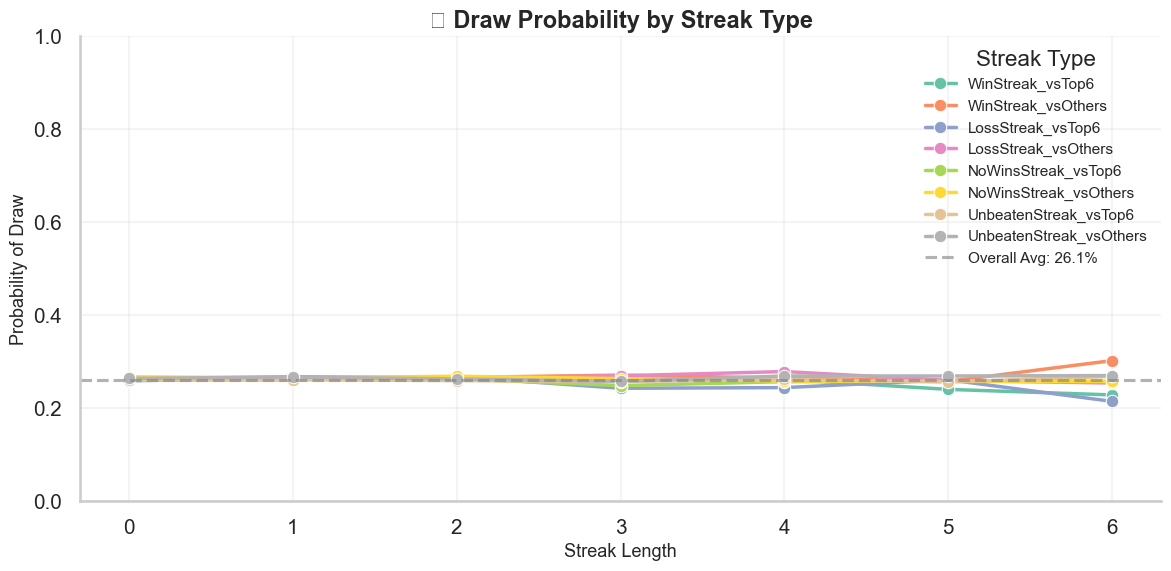

In [26]:
plot_draw_trends_combined(
    team_df,
    streak_columns=[
        'WinStreak_vsTop6', 'WinStreak_vsOthers',
        'LossStreak_vsTop6', 'LossStreak_vsOthers',
        'NoWinsStreak_vsTop6', 'NoWinsStreak_vsOthers',
        'UnbeatenStreak_vsTop6', 'UnbeatenStreak_vsOthers'
    ]
)


In [41]:
def plot_draw_distribution_with_custom_legend(df, streak_columns, max_streak_length=6):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from matplotlib.lines import Line2D

    sns.set_style("whitegrid")
    sns.set_context("talk", font_scale=0.9)

    # Friendly names for legend
    label_map = {
        'WinStreak_vsTop6': 'Win Streak vs Top 6',
        'WinStreak_vsOthers': 'Win Streak vs Others',
        'LossStreak_vsTop6': 'Loss Streak vs Top 6',
        'LossStreak_vsOthers': 'Loss Streak vs Others',
        'NoWinsStreak_vsTop6': 'No Wins vs Top 6',
        'NoWinsStreak_vsOthers': 'No Wins vs Others',
        'UnbeatenStreak_vsTop6': 'Unbeaten vs Top 6',
        'UnbeatenStreak_vsOthers': 'Unbeaten vs Others',
    }

    # Collect draw probability data
    all_data = []
    for col in streak_columns:
        for s in range(0, max_streak_length + 1):
            subset = df[df[col] == s]
            if not subset.empty:
                draw_prob = subset['NextOutcome'].value_counts(normalize=True).get('D', np.nan)
                all_data.append({'DrawProb': draw_prob, 'StreakType': col})

    plot_df = pd.DataFrame(all_data).dropna()
    plot_df['StreakType'] = pd.Categorical(
        plot_df['StreakType'], categories=streak_columns, ordered=True
    )

    # Build color map
    palette = sns.color_palette("husl", n_colors=len(streak_columns))
    color_map = dict(zip(streak_columns, palette))

    # Start plot
    fig, ax = plt.subplots(figsize=(13, 6))

    # Plot each KDE individually
    legend_handles = []
    for col in streak_columns:
        streak_data = plot_df[plot_df["StreakType"] == col]
        if not streak_data.empty:
            sns.kdeplot(
                data=streak_data,
                x="DrawProb",
                fill=True,
                alpha=0.4,
                linewidth=2,
                color=color_map[col],
                ax=ax
            )
            # Add to custom legend
            legend_handles.append(Line2D(
                [0], [0], color=color_map[col], lw=3,
                label=label_map[col]
            ))

    # Add average reference line
    overall_avg = plot_df["DrawProb"].mean()
    ax.axvline(overall_avg, linestyle='--', color='gray', alpha=0.7, linewidth=1.5)
    ax.text(overall_avg + 0.002, ax.get_ylim()[1]*0.95,
            f"Overall Avg: {overall_avg:.1%}", color='gray', fontsize=10)

    # Final styling
    ax.set_title("🎯 Distribution of Draw Probabilities by Streak Type", fontsize=16, weight='bold')
    ax.set_xlabel("Probability of Draw", fontsize=13)
    ax.set_ylabel("Density", fontsize=13)
    ax.set_xlim(0.18, 0.36)
    ax.grid(alpha=0.2)

    # Add custom legend
    ax.legend(handles=legend_handles, title="Streak Type",
              bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0, frameon=False)

    sns.despine()
    plt.tight_layout()
    plt.show()


In [58]:
team_df.columns

Index(['Div', 'Date', 'Time', 'Referee', 'Attendance', 'HTR', 'FTR', 'Team',
       'Opponent', 'Goals', 'GoalsConceded', 'HTGoals', 'HTGoalsConceded',
       'Shots', 'ShotsOnTarget', 'HitWoodwork', 'Corners', 'Fouls',
       'FreeKicksConceded', 'Offsides', 'YellowCards', 'RedCards',
       'BookingPoints', 'IsHome', 'Points', 'CumulativePoints',
       'LeaguePosition', 'Result', 'NextOutcome', 'WinStreak',
       'UnbeatenStreak', 'LossStreak', 'NoWinsStreak', 'PointsEarned',
       'Season', 'MatchIndex', 'OpponentTop6', 'WinStreak_vsTop6',
       'WinStreak_vsOthers', 'LossStreak_vsTop6', 'LossStreak_vsOthers',
       'NoWinsStreak_vsTop6', 'NoWinsStreak_vsOthers', 'UnbeatenStreak_vsTop6',
       'UnbeatenStreak_vsOthers'],
      dtype='object')

C:\Users\Jack\AppData\Local\Temp\ipykernel_17276\3587646337.py:82: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


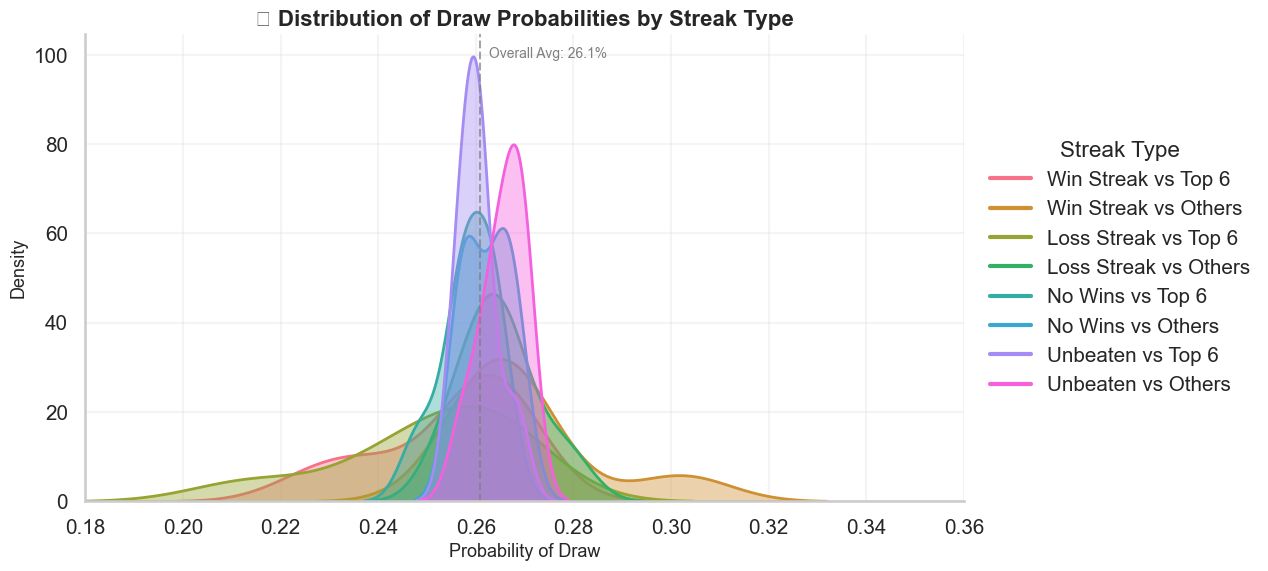

In [42]:
plot_draw_distribution_with_custom_legend(
    team_df,
    streak_columns=[
        'WinStreak_vsTop6', 'WinStreak_vsOthers',
        'LossStreak_vsTop6', 'LossStreak_vsOthers',
        'NoWinsStreak_vsTop6', 'NoWinsStreak_vsOthers',
        'UnbeatenStreak_vsTop6', 'UnbeatenStreak_vsOthers'
    ]
)

In [48]:
def plot_win_loss_distribution_with_custom_legend_final(df, streak_columns, max_streak_length=6):
    """
    Create KDE distribution plots for Win and Loss probabilities by streak type.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from matplotlib.lines import Line2D

    sns.set_style("whitegrid")
    sns.set_context("talk", font_scale=0.9)

    label_map = {
        'WinStreak_vsTop6': 'Win Streak vs Top 6',
        'WinStreak_vsOthers': 'Win Streak vs Others',
        'LossStreak_vsTop6': 'Loss Streak vs Top 6',
        'LossStreak_vsOthers': 'Loss Streak vs Others',
        'NoWinsStreak_vsTop6': 'No Wins vs Top 6',
        'NoWinsStreak_vsOthers': 'No Wins vs Others',
        'UnbeatenStreak_vsTop6': 'Unbeaten vs Top 6',
        'UnbeatenStreak_vsOthers': 'Unbeaten vs Others',
    }

    # Collect outcome probability data
    all_data = []
    for col in streak_columns:
        for s in range(0, max_streak_length + 1):
            subset = df[df[col] == s]
            if not subset.empty:
                counts = subset['NextOutcome'].value_counts(normalize=True)
                all_data.append({
                    'WinProb': counts.get('W', np.nan),
                    'LossProb': counts.get('L', np.nan),
                    'StreakType': col
                })

    plot_df = pd.DataFrame(all_data).dropna()
    plot_df['StreakType'] = pd.Categorical(plot_df['StreakType'], categories=streak_columns, ordered=True)

    palette = sns.color_palette("husl", n_colors=len(streak_columns))
    color_map = dict(zip(streak_columns, palette))

    # --- WIN PROBABILITY ---
    fig, ax = plt.subplots(figsize=(13, 6))
    legend_handles = []

    for col in streak_columns:
        streak_data = plot_df[plot_df["StreakType"] == col]
        if not streak_data.empty:
            sns.kdeplot(
                data=streak_data,
                x="WinProb",
                fill=True,
                alpha=0.4,
                linewidth=2,
                color=color_map[col],
                ax=ax
            )
            legend_handles.append(Line2D(
                [0], [0], color=color_map[col], lw=3, label=label_map[col]
            ))

    overall_avg = plot_df["WinProb"].mean()
    ax.axvline(overall_avg, linestyle='--', color='gray', alpha=0.7, linewidth=1.5)
    ax.text(overall_avg + 0.002, ax.get_ylim()[1]*0.95,
            f"Overall Avg: {overall_avg:.1%}", color='gray', fontsize=10)

    ax.set_title("Distribution of Win Probabilities by Streak Type", fontsize=16, weight='bold')
    ax.set_xlabel("Probability of Win", fontsize=13)
    ax.set_ylabel("Density", fontsize=13)
    ax.set_xlim(0.18, 0.7)
    ax.grid(alpha=0.2)
    ax.legend(handles=legend_handles, title="Streak Type",
              bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0, frameon=False)
    sns.despine()
    plt.tight_layout()
    plt.show()

    # --- LOSS PROBABILITY ---
    fig, ax = plt.subplots(figsize=(13, 6))
    legend_handles = []

    for col in streak_columns:
        streak_data = plot_df[plot_df["StreakType"] == col]
        if not streak_data.empty:
            sns.kdeplot(
                data=streak_data,
                x="LossProb",
                fill=True,
                alpha=0.4,
                linewidth=2,
                color=color_map[col],
                ax=ax
            )
            legend_handles.append(Line2D(
                [0], [0], color=color_map[col], lw=3, label=label_map[col]
            ))

    overall_avg = plot_df["LossProb"].mean()
    ax.axvline(overall_avg, linestyle='--', color='gray', alpha=0.7, linewidth=1.5)
    ax.text(overall_avg + 0.002, ax.get_ylim()[1]*0.95,
            f"Overall Avg: {overall_avg:.1%}", color='gray', fontsize=10)

    ax.set_title("Distribution of Loss Probabilities by Streak Type", fontsize=16, weight='bold')
    ax.set_xlabel("Probability of Loss", fontsize=13)
    ax.set_ylabel("Density", fontsize=13)
    ax.set_xlim(0.18, 0.7)
    ax.grid(alpha=0.2)
    ax.legend(handles=legend_handles, title="Streak Type",
              bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0, frameon=False)
    sns.despine()
    plt.tight_layout()
    plt.show()

    return plot_df  # In case further analysis is needed



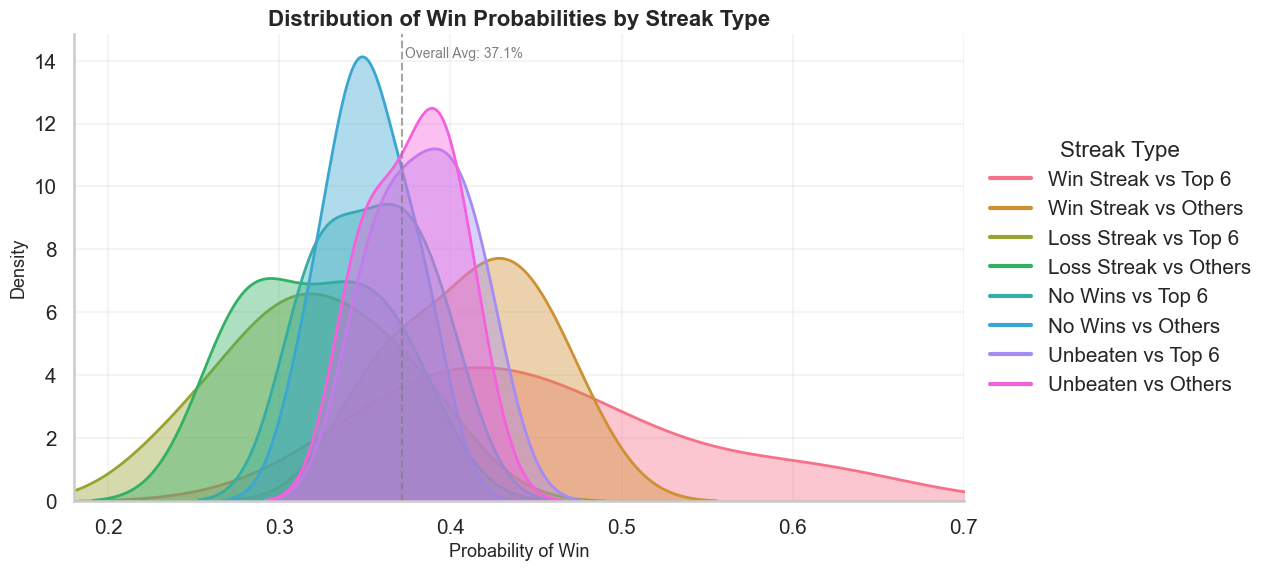

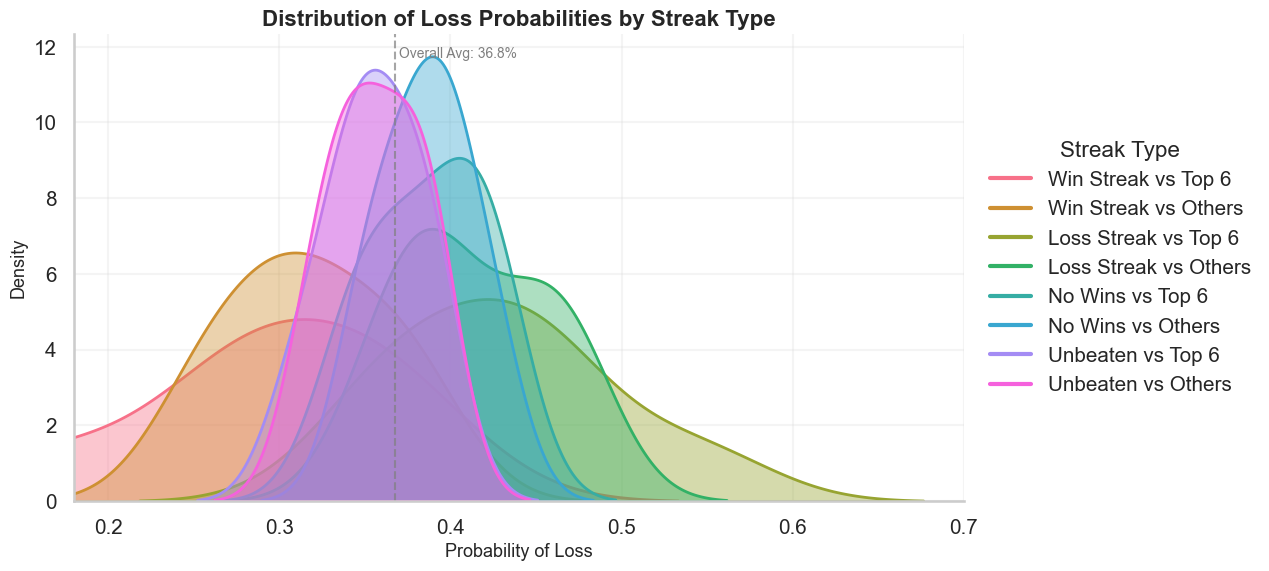

,WinProb,LossProb,StreakType
0,0.359258,0.382266,WinStreak_vsTop6
1,0.376258,0.358203,WinStreak_vsTop6
2,0.400704,0.334056,WinStreak_vsTop6
3,0.442502,0.294553,WinStreak_vsTop6
4,0.456140,0.282164,WinStreak_vsTop6
5,0.506579,0.253289,WinStreak_vsTop6
6,0.610738,0.161074,WinStreak_vsTop6
7,0.352430,0.384262,WinStreak_vsOthers
8,0.369209,0.363523,WinStreak_vsOthers
9,0.399139,0.335126,WinStreak_vsOthers


In [49]:
plot_win_loss_distribution_with_custom_legend_final(
    df=team_df,  # or your relevant DataFrame
    streak_columns=[
        'WinStreak_vsTop6', 'WinStreak_vsOthers',
        'LossStreak_vsTop6', 'LossStreak_vsOthers',
        'NoWinsStreak_vsTop6', 'NoWinsStreak_vsOthers',
        'UnbeatenStreak_vsTop6', 'UnbeatenStreak_vsOthers'
    ],
    max_streak_length=6
)


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_violin_draw_probs_by_streak(df, streak_columns, max_streak_length=6):
    """
    Plot a violin plot of draw probabilities for each streak type to detect bimodal patterns.
    """
    label_map = {
        'WinStreak_vsTop6': 'Win Streak vs Top 6',
        'WinStreak_vsOthers': 'Win Streak vs Others',
        'LossStreak_vsTop6': 'Loss Streak vs Top 6',
        'LossStreak_vsOthers': 'Loss Streak vs Others',
        'NoWinsStreak_vsTop6': 'No Wins vs Top 6',
        'NoWinsStreak_vsOthers': 'No Wins vs Others',
        'UnbeatenStreak_vsTop6': 'Unbeaten vs Top 6',
        'UnbeatenStreak_vsOthers': 'Unbeaten vs Others',
    }

    # Collect draw probabilities per streak type
    all_data = []
    for col in streak_columns:
        for s in range(0, max_streak_length + 1):
            subset = df[df[col] == s]
            if not subset.empty:
                prob = subset['NextOutcome'].value_counts(normalize=True).get('D', np.nan)
                all_data.append({'DrawProb': prob, 'StreakType': col})

    plot_df = pd.DataFrame(all_data).dropna()
    plot_df['Streak Label'] = plot_df['StreakType'].map(label_map)

    # Plot
    sns.set(style="whitegrid", context="talk", font_scale=0.9)
    plt.figure(figsize=(14, 6))

    ax = sns.violinplot(
        data=plot_df,
        x='Streak Label',
        y='DrawProb',
        inner='quartile',
        scale='width',
        linewidth=1.2,
        palette='Set2'
    )

    # Annotate
    avg = plot_df['DrawProb'].mean()
    plt.axhline(avg, linestyle='--', color='gray', alpha=0.7)
    plt.text(len(streak_columns) - 0.5, avg + 0.002, f"Overall Avg: {avg:.1%}", color='gray')

    plt.title("🎭 Distribution of Draw Probabilities by Streak Type", fontsize=16, weight='bold')
    plt.ylabel("Probability of Draw")
    plt.xlabel("Streak Type")
    plt.xticks(rotation=25, ha='right')
    plt.ylim(0.15, 0.35)

    sns.despine()
    plt.tight_layout()
    plt.show()


C:\Users\Jack\AppData\Local\Temp\ipykernel_17276\1390433027.py:59: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


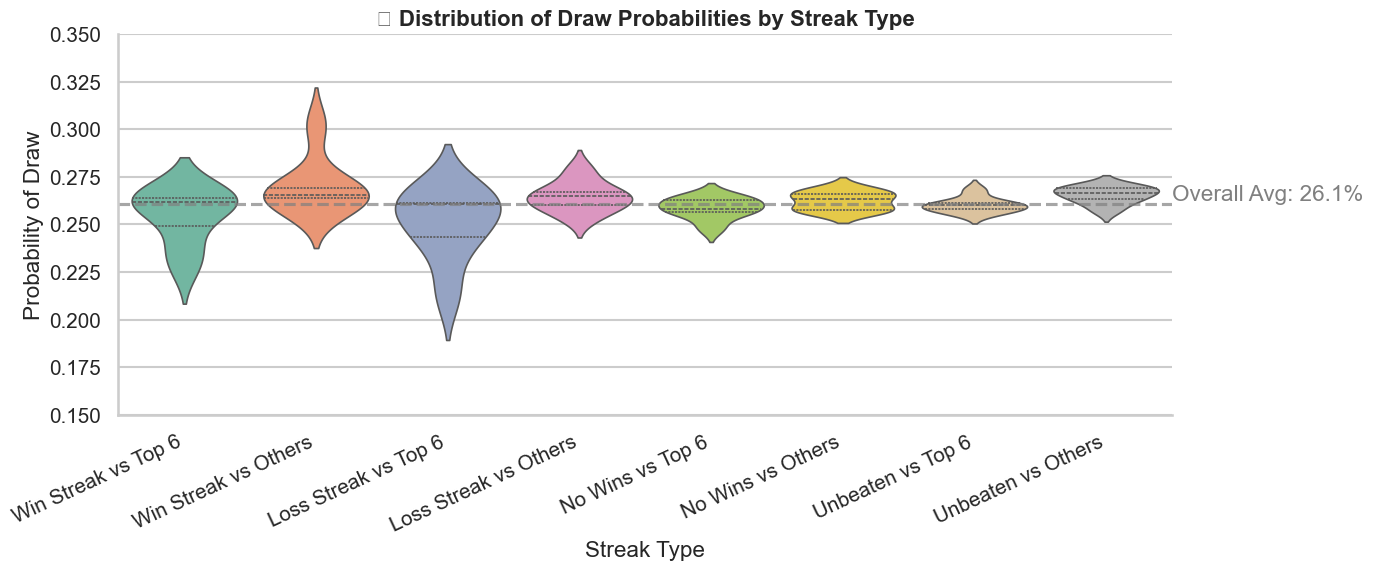

In [51]:
plot_violin_draw_probs_by_streak(
    df=team_df,  # or your relevant DataFrame
    streak_columns=[
        'WinStreak_vsTop6', 'WinStreak_vsOthers',
        'LossStreak_vsTop6', 'LossStreak_vsOthers',
        'NoWinsStreak_vsTop6', 'NoWinsStreak_vsOthers',
        'UnbeatenStreak_vsTop6', 'UnbeatenStreak_vsOthers'
    ],
    max_streak_length=6
)

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_violin_swarm_draw_distribution(df, streak_columns, max_streak_length=6):
    # Label mapping
    label_map = {
        'WinStreak_vsTop6': 'Win Streak vs Top 6',
        'WinStreak_vsOthers': 'Win Streak vs Others',
        'LossStreak_vsTop6': 'Loss Streak vs Top 6',
        'LossStreak_vsOthers': 'Loss Streak vs Others',
        'NoWinsStreak_vsTop6': 'No Wins vs Top 6',
        'NoWinsStreak_vsOthers': 'No Wins vs Others',
        'UnbeatenStreak_vsTop6': 'Unbeaten vs Top 6',
        'UnbeatenStreak_vsOthers': 'Unbeaten vs Others',
    }

    # Collect draw probabilities
    all_data = []
    for col in streak_columns:
        for s in range(0, max_streak_length + 1):
            subset = df[df[col] == s]
            if not subset.empty:
                draw_prob = subset['NextOutcome'].value_counts(normalize=True).get('D', np.nan)
                all_data.append({
                    'DrawProb': draw_prob,
                    'StreakType': col,
                    'Streak Label': label_map[col]
                })

    plot_df = pd.DataFrame(all_data).dropna()

    sns.set(style="whitegrid", context="talk")
    fig, ax = plt.subplots(figsize=(14, 6))

    # Violin plot
    sns.violinplot(
        data=plot_df,
        x="Streak Label",
        y="DrawProb",
        inner="quartile",
        palette="Set2",
        cut=0,
        ax=ax
    )

    # Swarm plot on top
    sns.swarmplot(
        data=plot_df,
        x="Streak Label",
        y="DrawProb",
        color='black',
        size=3,
        alpha=0.6,
        ax=ax
    )

    # Average line
    overall_avg = plot_df["DrawProb"].mean()
    ax.axhline(overall_avg, linestyle='--', color='gray', linewidth=1.5)
    ax.text(len(streak_columns) - 0.5, overall_avg + 0.005,
            f"Overall Avg: {overall_avg:.1%}",
            color='gray', fontsize=10, ha='right')

    # Styling
    ax.set_title("🎯 Distribution of Draw Probabilities by Streak Type", fontsize=16, weight='bold')
    ax.set_ylabel("Probability of Draw", fontsize=12)
    ax.set_xlabel("Streak Type", fontsize=12)
    ax.set_ylim(0.15, 0.35)
    ax.tick_params(axis='x', rotation=30)
    sns.despine()
    plt.tight_layout()
    plt.show()


C:\Users\Jack\AppData\Local\Temp\ipykernel_17276\138550902.py:73: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Jack\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


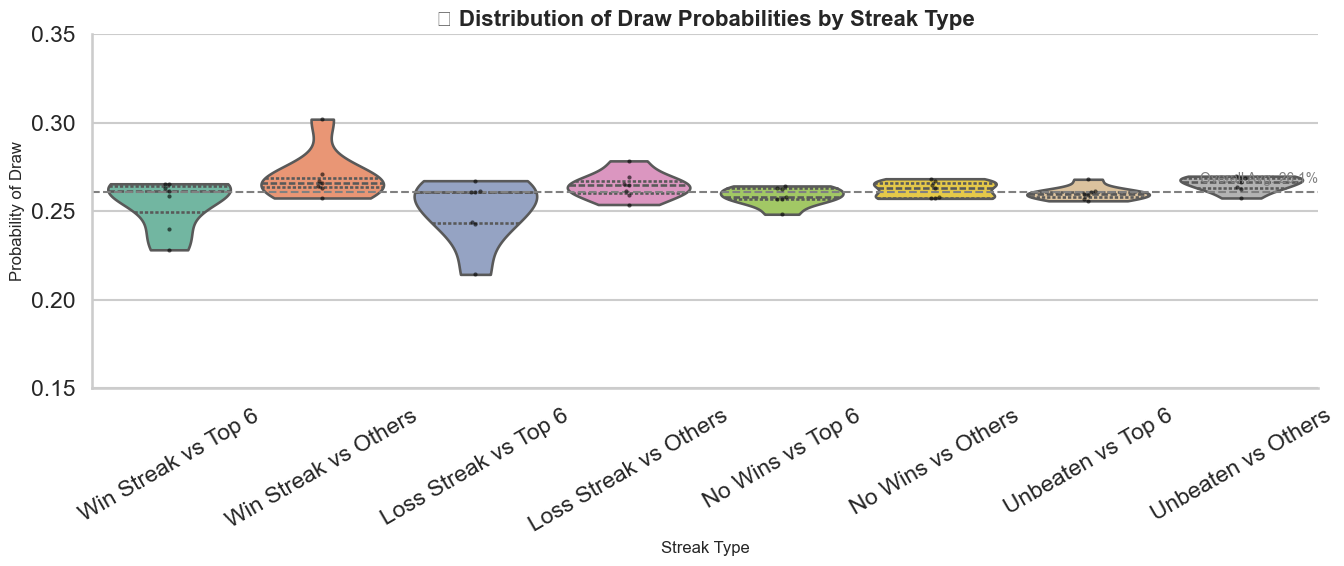

In [53]:
streak_columns = [
    'WinStreak_vsTop6', 'WinStreak_vsOthers',
    'LossStreak_vsTop6', 'LossStreak_vsOthers',
    'NoWinsStreak_vsTop6','NoWinsStreak_vsOthers',
    'UnbeatenStreak_vsTop6','UnbeatenStreak_vsOthers'
]

plot_violin_swarm_draw_distribution(df=team_df, streak_columns=streak_columns)


In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_draw_distribution_by_team(team_df, division='E0', min_season=2020):
    sns.set_style("whitegrid")
    sns.set_context("talk", font_scale=0.9)

    # Filter for division and season
    df_filtered = team_df[(team_df['Div'] == division) & (team_df['Season'] >= min_season)].copy()

    # Ensure only valid outcomes
    df_filtered = df_filtered[df_filtered['NextOutcome'].isin(['W', 'D', 'L'])]

    # Calculate draw probability for each team
    draw_data = []
    for team in df_filtered['Team'].unique():
        team_subset = df_filtered[df_filtered['Team'] == team]
        draw_probs = (
            team_subset.groupby('Season')['NextOutcome']
            .value_counts(normalize=True)
            .unstack()
            .get('D', pd.Series([0]))
        )
        for prob in draw_probs:
            draw_data.append({'Team': team, 'DrawProb': prob})

    plot_df = pd.DataFrame(draw_data)

    # Plot
    fig, ax = plt.subplots(figsize=(13, 6))
    sns.kdeplot(data=plot_df, x='DrawProb', hue='Team', fill=True, common_norm=False,
                alpha=0.4, linewidth=2)

    avg = plot_df['DrawProb'].mean()
    ax.axvline(avg, linestyle='--', color='gray', alpha=0.7, linewidth=1.5)
    ax.text(avg + 0.002, ax.get_ylim()[1]*0.95, f"Overall Avg: {avg:.1%}", color='gray', fontsize=10)

    ax.set_title("Draw Probability Distribution by Team (E0, Last 5 Seasons)", fontsize=16, weight='bold')
    ax.set_xlabel("Probability of Draw", fontsize=13)
    ax.set_ylabel("Density", fontsize=13)
    ax.set_xlim(0.1, 0.45)
    ax.get_legend().remove()
    ax.grid(alpha=0.2)
    sns.despine()
    plt.tight_layout()
    plt.show()


C:\Users\Jack\AppData\Local\Temp\ipykernel_17276\1304675354.py:33: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=plot_df, x='DrawProb', hue='Team', fill=True, common_norm=False,


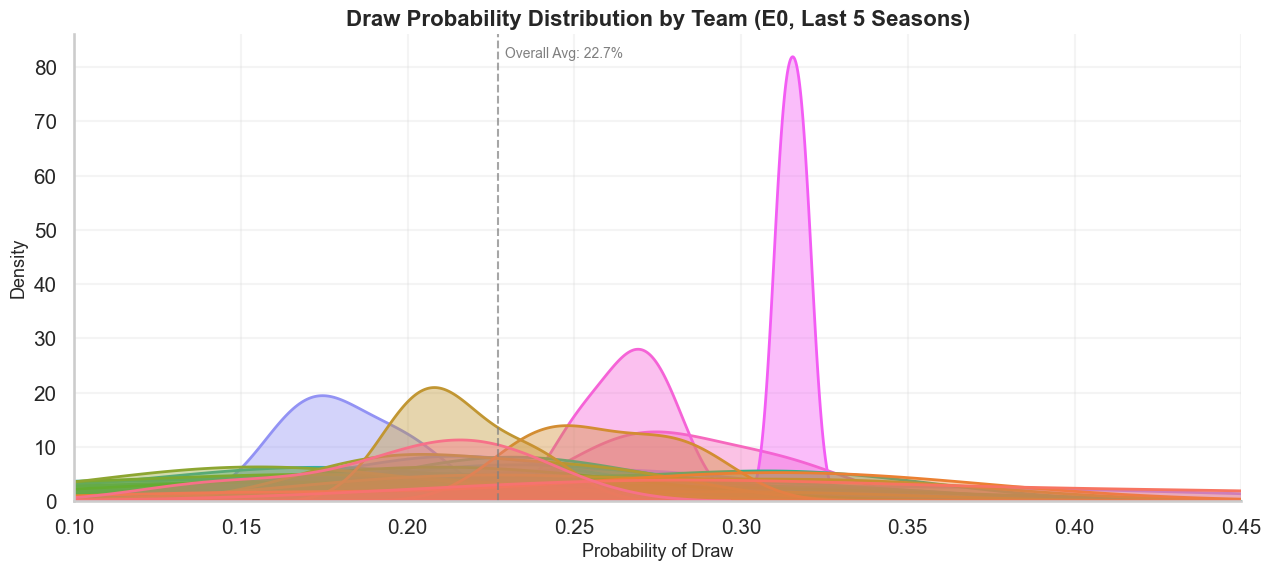

In [84]:
plot_draw_distribution_by_team(team_df)
